In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

import sys
sys.path.append('..')

from datetime import datetime

import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc

from bizdays import Calendar

from brasa.parsers.b3.futures_settlement_prices import maturity2date
import brasa

In [2]:
man = brasa.CacheManager()
cal = Calendar.load("ANBIMA")

In [3]:
ds_bvbg028_eo = brasa.get_dataset("b3-bvbg028-options_on_equities")

In [4]:
ds_bvbg028_eo.schema

creation_date: timestamp[us]
refdate: timestamp[us]
security_id: int64
security_proprietary: int64
security_market: string
instrument_asset: string
instrument_asset_description: string
instrument_market: int64
instrument_segment: int64
instrument_description: string
security_category: int64
isin: string
symbol: string
exercise_price: double
option_style: string
maturity_date: timestamp[us]
option_type: string
underlying_security_id: int64
underlying_security_proprietary: int64
protection_flag: bool
premium_upfront_indicator: bool
trading_start_date: timestamp[us]
trading_end_date: timestamp[us]
payment_type: int64
allocation_lot_size: int64
price_factor: int64
trading_currency: string
days_to_settlement: int64
delivery_type: int64
automatic_exercise_indicator: bool
instrument_type: string
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 4366

In [5]:
cols = [
    'symbol',
    'refdate',
    'security_id',
    'security_proprietary',
    'security_market',
    'instrument_asset',
    'instrument_asset_description',
    'instrument_market',
    'instrument_segment',
    'instrument_description',
    'security_category',
    'isin',
    'exercise_price',
    'option_style',
    'maturity_date',
    'option_type',
    'underlying_security_id',
    'underlying_security_proprietary',
    'protection_flag',
    'premium_upfront_indicator',
    'trading_start_date',
    'trading_end_date',
    'payment_type',
    'allocation_lot_size',
    'price_factor',
    'trading_currency',
    'days_to_settlement',
    'delivery_type',
    'automatic_exercise_indicator',
    'instrument_type',
]

df_bvbg028_eo = ds_bvbg028_eo.to_table(columns=cols).to_pandas()

In [ ]:
tb_bvbg028_eo = pa.Table.from_pandas(df_bvbg028_eo)
ds.write_dataset(tb_bvbg028_eo, man.db_path("b3-options-on-equities-register"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [13]:
ds_marketdata = brasa.get_dataset("b3-bvbg086")
ds_marketdata.schema

In [17]:
cols = [
    "refdate",
    "symbol",
    "trade_quantity",
    "volume",
    "traded_contracts",
    "oscillation_percentage",
]

df_marketdata = ds_marketdata.filter(pc.field("symbol").isin(df_bvbg028_eo["symbol"])).filter(~pc.is_null(pc.field("oscillation_percentage"))).to_table(columns=cols).to_pandas()
df_marketdata

,refdate,symbol,trade_quantity,volume,traded_contracts,oscillation_percentage
0,2018-01-02,IVVB11,270.0,4202309.00,45630.0,-1.52
1,2018-01-02,OSXB3,6.0,9948.00,1300.0,-0.78
2,2018-01-02,LLIS3,9.0,265062.00,8300.0,-2.46
3,2018-01-02,BRIN3,96.0,401695.00,32900.0,-1.88
4,2018-01-02,CGRA4,58.0,434014.00,15800.0,-0.16
...,...,...,...,...,...,...
1197438,2023-07-28,PDGR3,147.0,193414.00,35400.0,0.90
1197439,2023-07-28,B1IL34,54.0,60412.56,3413.0,15.05
1197440,2023-07-28,CEDO4,19.0,37926.00,3200.0,-1.62
1197441,2023-07-28,META11,7.0,443.59,16.0,-1.03


In [18]:
import numpy as np


df_marketdata["pct_return"] = df_marketdata["oscillation_percentage"] / 100
df_marketdata["log_return"] = np.exp(df_marketdata["pct_return"]) - 1

c:\Users\wilso\AppData\Local\pypoetry\Cache\virtualenvs\brasa-iv4UAxlw-py3.10\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:
df_marketdata.sort_values(["refdate", "symbol"], inplace=True)

<Axes: xlabel='refdate'>

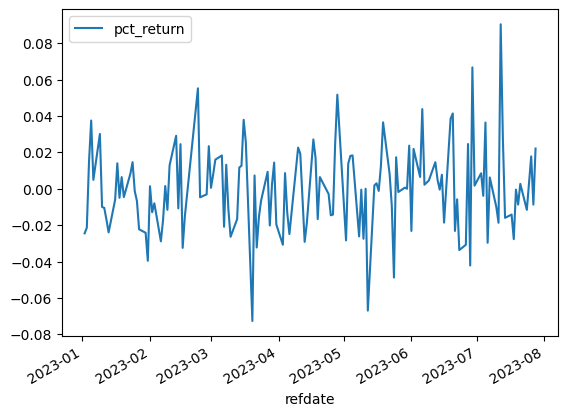

In [20]:
df_marketdata.query("symbol == 'JBSS3'").query("refdate > '2023-01-01'").plot(x="refdate", y="pct_return")

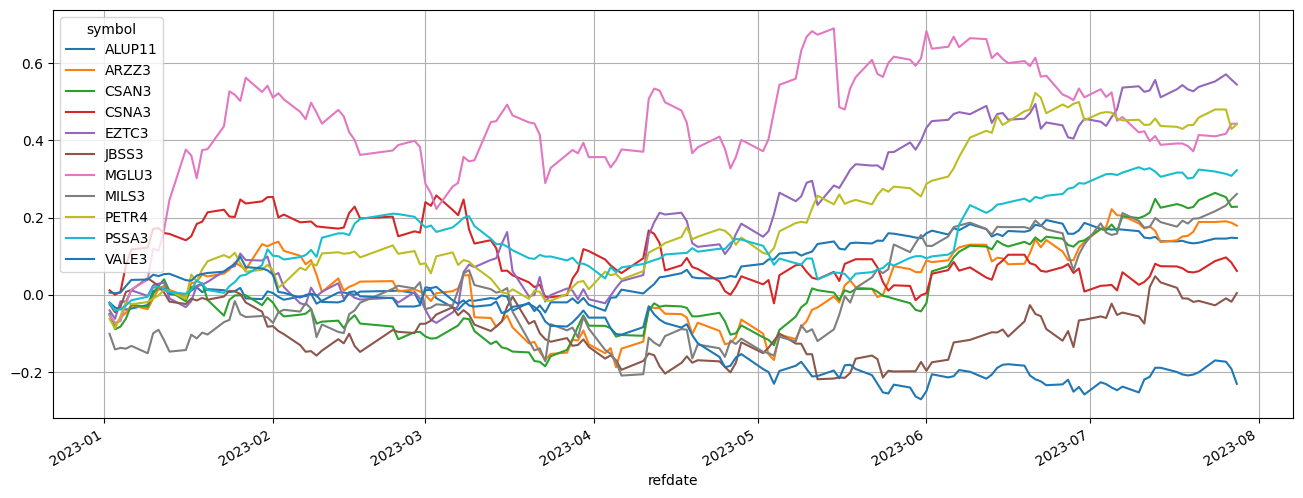

In [21]:
symbols = ["VALE3", "PETR4", "JBSS3", "EZTC3", "ARZZ3", "MGLU3", "PSSA3", "MILS3", "CSAN3", "CSNA3", "ALUP11"]
df_marketdata[df_marketdata.symbol.isin(symbols)]\
    .query("refdate > '2023-01-01'").pivot(columns="symbol", index="refdate", values="log_return").cumsum().plot(figsize=(16, 6)).grid()

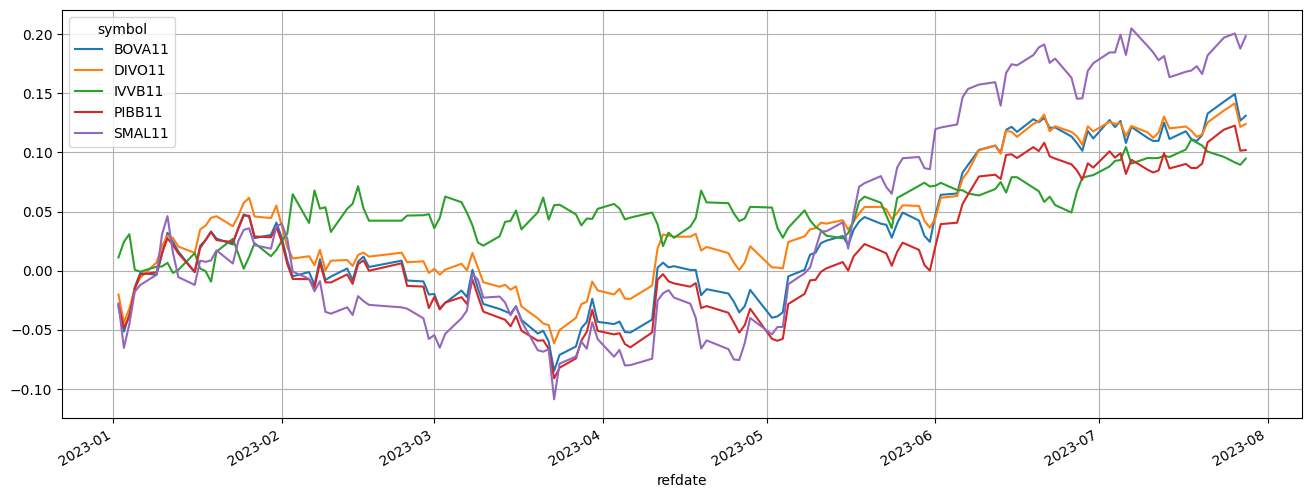

In [22]:
symbols = ["PIBB11", "BOVA11", "IVVB11", "DIVO11", "SMAL11", ""]
df_marketdata[df_marketdata.symbol.isin(symbols)]\
    .query("refdate > '2023-01-01'").pivot(columns="symbol", index="refdate", values="log_return").cumsum().plot(figsize=(16, 6)).grid()

In [23]:
tb_equities = pa.Table.from_pandas(df_equities)
ds.write_dataset(tb_equities, man.db_path("b3-equities-register"), format="parquet", existing_data_behavior="overwrite_or_ignore")
tb_marketdata = pa.Table.from_pandas(df_marketdata)
ds.write_dataset(tb_marketdata, man.db_path("b3-equities-marketdata"), format="parquet", existing_data_behavior="overwrite_or_ignore")

In [24]:
ds_index = brasa.get_dataset("b3-bvbg087-indexes_info")
ds_index.schema

cols = [
    "refdate",
    "symbol",
    "security_id",
    "security_proprietary",
    "security_market",
    "asset_desc",
    "settlement_price",
    "open_price",
    "min_price",
    "max_price",
    "average_price",
    "close_price",
    "last_price",
    "oscillation_val",
    "rising_shares_number",
    "falling_shares_number",
    "stable_shares_number",
]

df_index = ds_index.to_table(columns=cols).to_pandas()
df_index

,refdate,symbol,security_id,security_proprietary,security_market,asset_desc,settlement_price,open_price,min_price,max_price,average_price,close_price,last_price,oscillation_val,rising_shares_number,falling_shares_number,stable_shares_number
0,2016-05-05,IFIX,4011052,8,BVMF,IND FDO IMOB,1551.7525,1547.02,1543.68,1554.41,1550.98,1552.09,1552.09,0.003257,28,31,11
1,2016-05-05,IVBX,4011110,8,BVMF,IVBX2,7863.9816,7955.01,7837.43,8003.80,7892.65,7855.13,7855.13,-0.012476,15,34,1
2,2016-05-05,IBXX,4010872,8,BVMF,IBRX BRASIL,21276.3836,21627.87,21139.58,21835.73,21419.57,21275.50,21275.50,-0.016284,24,74,2
3,2016-05-05,ICON,4010971,8,BVMF,ICONSUMO,2626.1435,2667.45,2616.89,2679.61,2636.69,2626.47,2626.47,-0.015224,10,22,1
4,2016-05-05,IBRA,4010963,8,BVMF,IBRASIL,1969.0053,2001.31,1956.52,2020.23,1982.14,1969.00,1969.00,-0.016140,31,83,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44270,2023-07-28,ISEE,10018391,8,BVMF,ISUSTENTABIL,3596.0000,3585.95,3583.44,3615.04,3596.40,3606.85,3606.85,0.005900,46,19,2
44271,2023-07-28,TFIX,200000032811,8,BVMF,INDICE TESTE,NaN,5294.50,2750.00,9250.00,5101.66,5000.00,5000.00,0.000000,3,3,4
44272,2023-07-28,BDRX,10018357,8,BVMF,BDRX,12967.0000,12772.42,12759.24,13068.75,12968.12,13017.70,13017.70,0.009400,78,49,2
44273,2023-07-28,IVBX,10018390,8,BVMF,IVBX2,13567.0000,13521.87,13504.09,13627.37,13560.28,13605.71,13605.71,0.006100,38,11,1


In [25]:
df_index["pct_return"] = df_index["oscillation_val"]
df_index["log_return"] = np.exp(df_index["pct_return"]) - 1

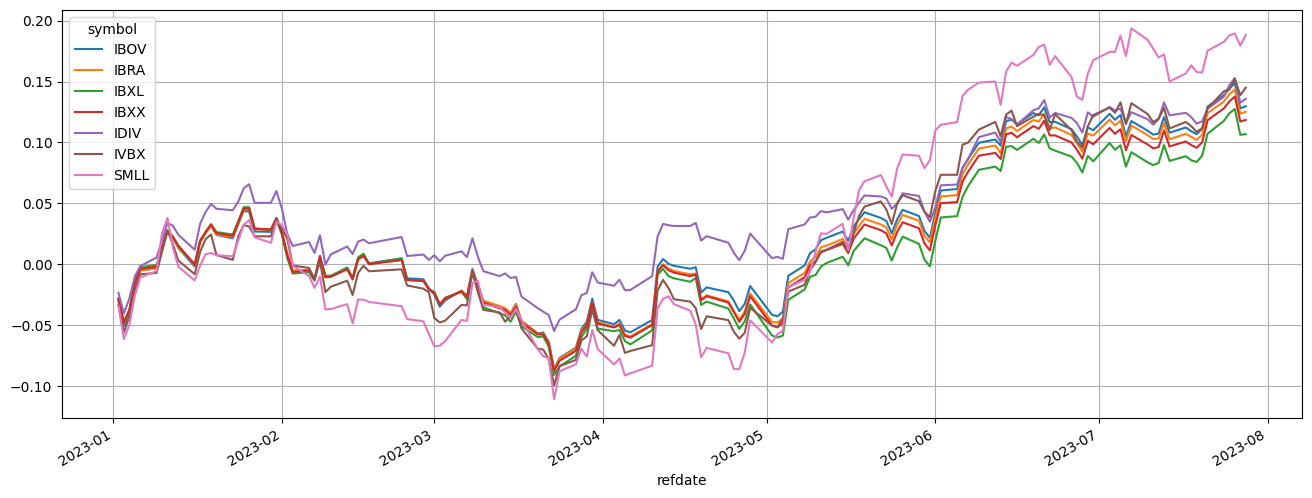

In [26]:
symbols = ["IBXX", "IBOV", "IBXL", "SMLL", "IDIV", "IVBX", "IBRA"]
df_index[df_index.symbol.isin(symbols)]\
    .query("refdate > '2023-01-01'").pivot(columns="symbol", index="refdate", values="log_return").cumsum().plot(figsize=(16, 6)).grid()

In [27]:
tb_index = pa.Table.from_pandas(df_index)
ds.write_dataset(tb_index, man.db_path("b3-indexes-marketdata"), format="parquet", existing_data_behavior="overwrite_or_ignore")